#  Model Evaluation
F1-score alongside accuracy will be the two primary evaluation metrics for assessing model performance due to their appropriateness in BCPs as discussed in section 2.2.5.


In [1]:
# Importing necessary libraries
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

All trained model were evaluated on the same unseen test set (loaded).

In [2]:
# Consistent sets
skin_df_test = pd.read_csv("skin_df_test.csv") # Loading test set
x_val = np.load("x_val.npy") # For threshold tuning assessment
y_val = np.load("y_val.npy") # For threshold tuning assessment
x_test = np.load("x_test.npy") # For evaluation
y_test = np.load("y_test.npy") # For evaluation

In [3]:
# Loading in trained models
model_og_LN = load_model("best_model_og_LN.keras")
model_manual_aug_LN = load_model("best_model_manual_aug_LN.keras")
model_gs_aug_LN = load_model("best_model_gs_aug_LN.keras")
model_gan_aug_LN = load_model("best_model_gan_aug_LN.keras")
model_og_EN = load_model("best_model_og_EN.keras")
model_manual_aug_EN = load_model("best_model_manual_aug_EN.keras")
model_gs_aug_EN = load_model("best_model_gs_aug_EN.keras")
model_gan_aug_EN = load_model("best_model_gan_aug_EN.keras")

In [4]:
LN = "LeNet5"
EN = "EfficientNetV2B0"
none = " w/ No Augmentations"
manual = " Balanced w/ Manual Set Parameter Augmentations"
gs = " Balanced w/ Grid Search Parameter Augmentations"
gan = " Balanced w/ GAN Augmentations"

models = [
    [model_og_LN, LN+none],
    [model_manual_aug_LN, LN+manual],
    [model_gs_aug_LN, LN+gs],
    [model_gan_aug_LN, LN+gan],
    [model_og_EN, EN+none],
    [model_manual_aug_EN, EN+manual],
    [model_gs_aug_EN, EN+gs],
    [model_gan_aug_EN, EN+gan]
]

### Training and Validation Loss/Accuracy Plotting
Outlined in section 3.5.3, results in section 4.2.

Using the training histories “.json” files, training and validation loss/accuracy plots were created (highlighting callback epochs) to assess the presence of any over-fitting/under-fitting.

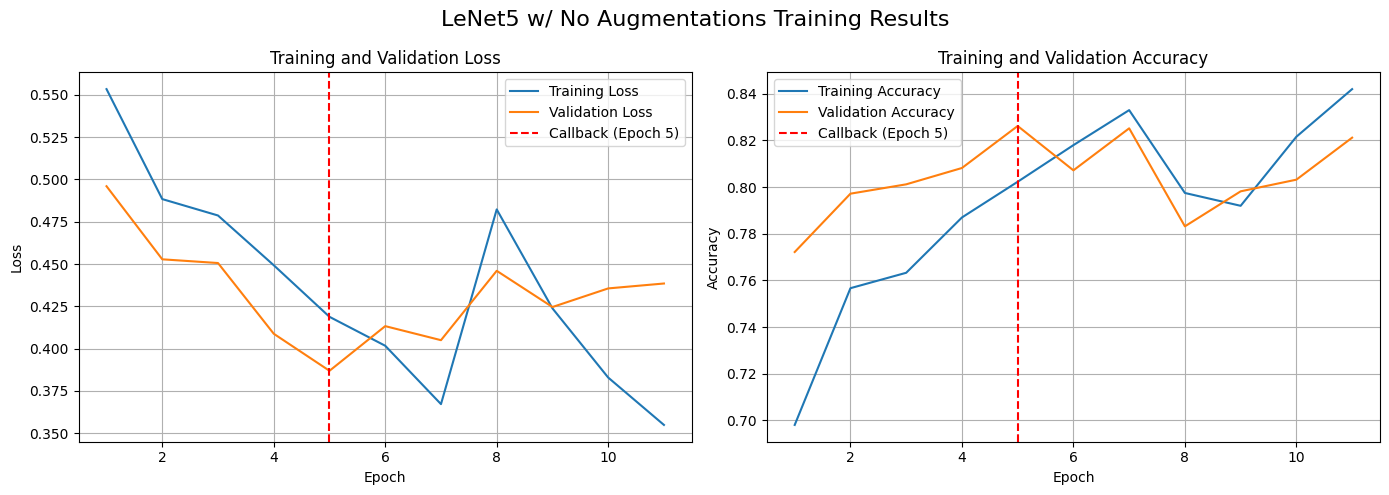

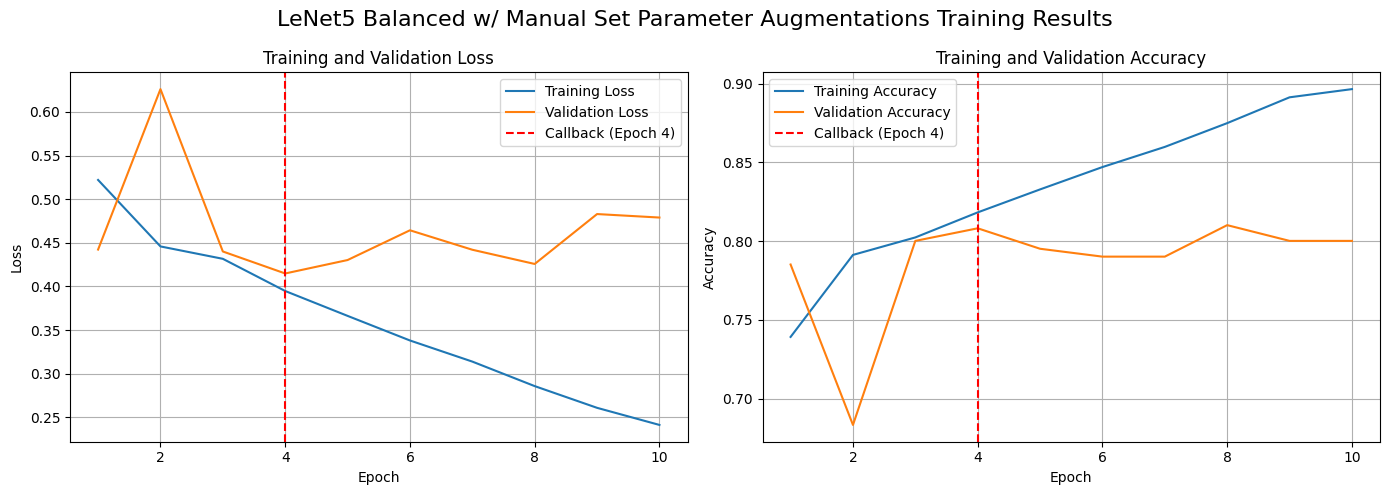

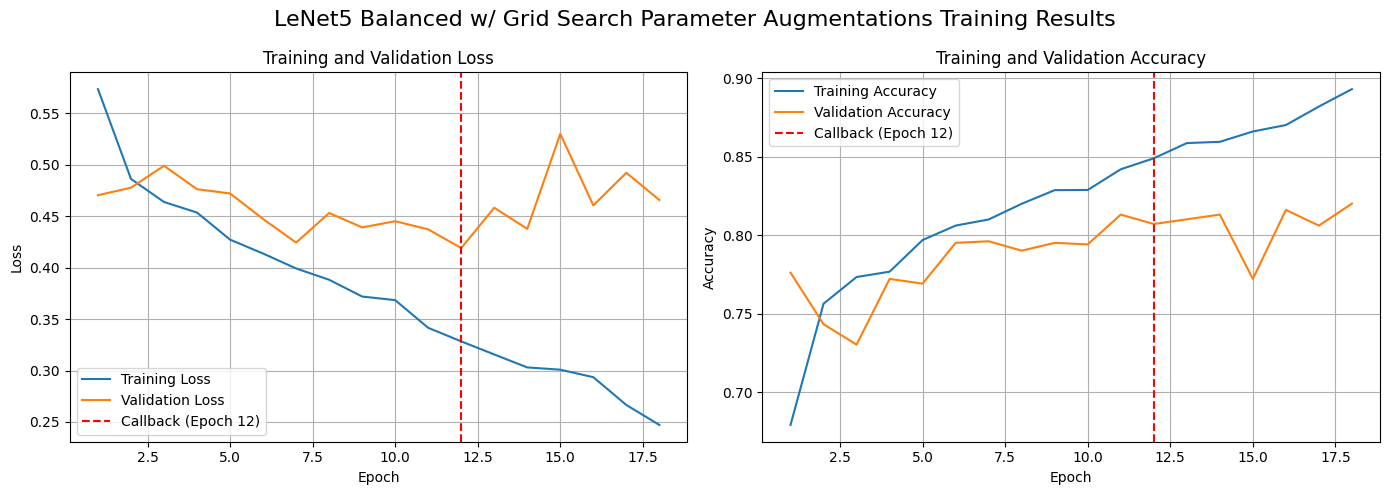

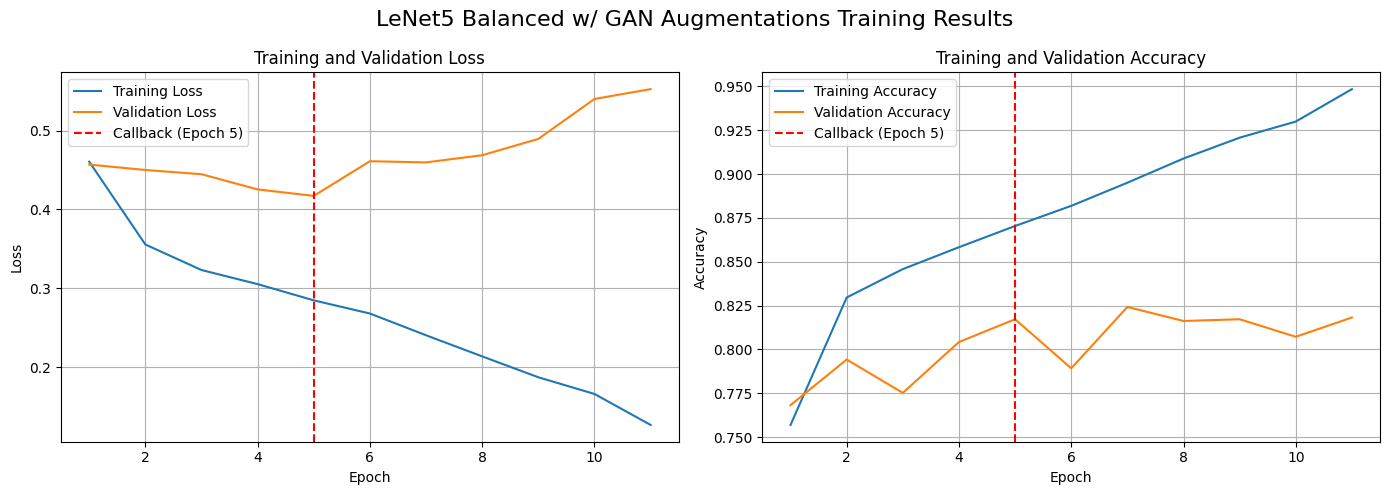

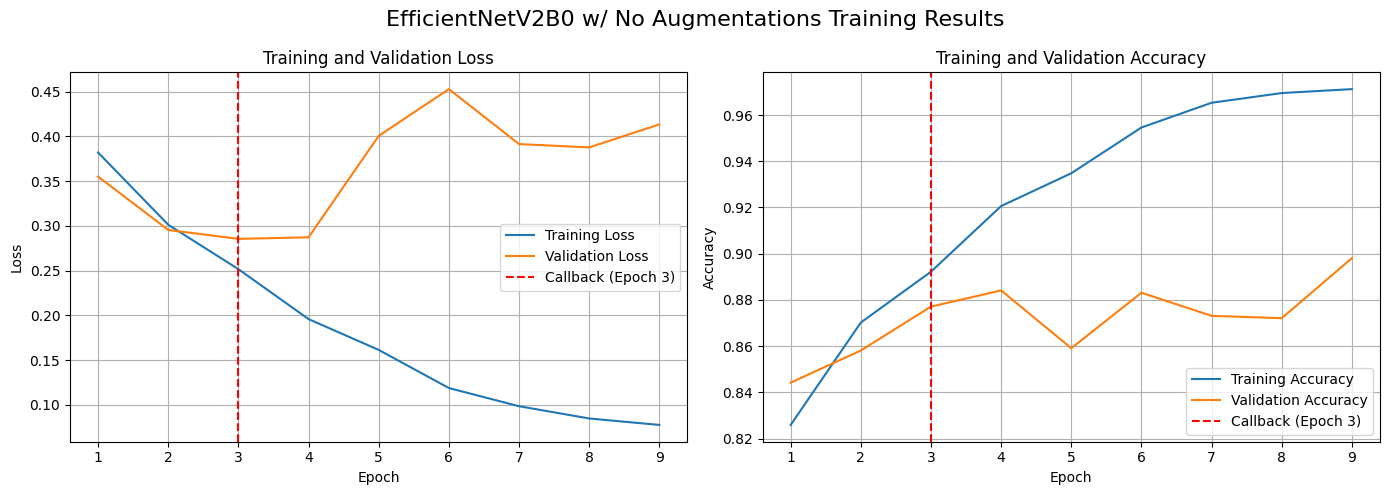

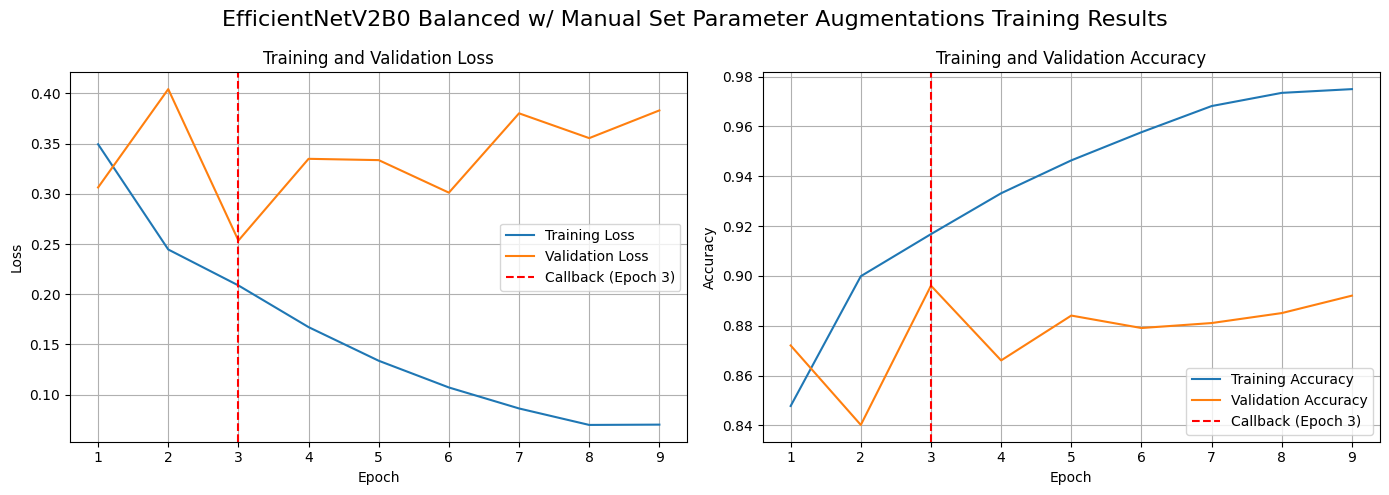

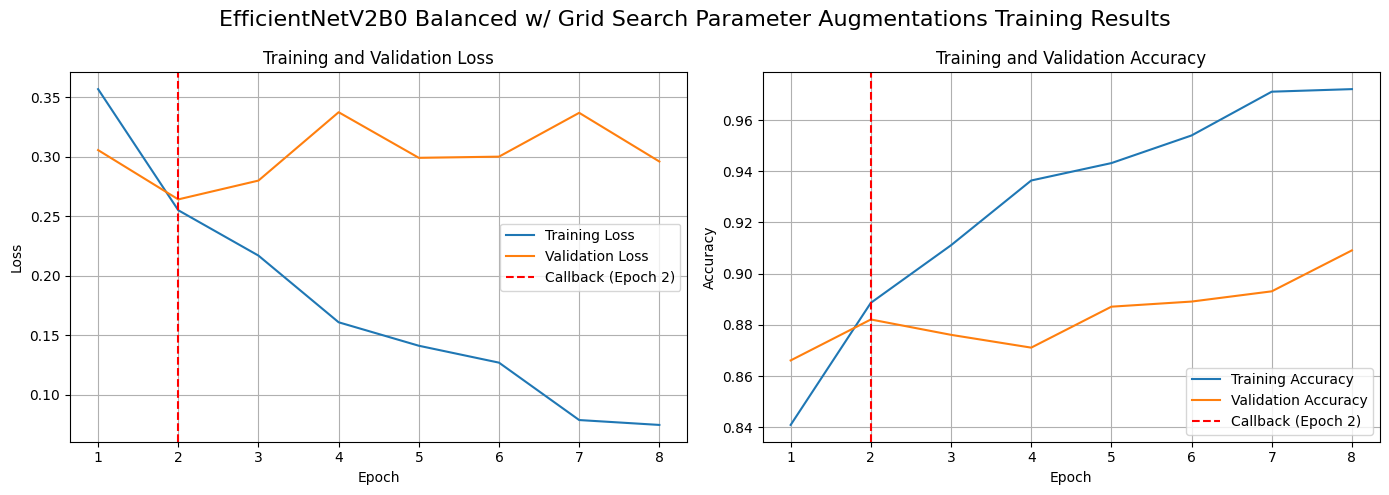

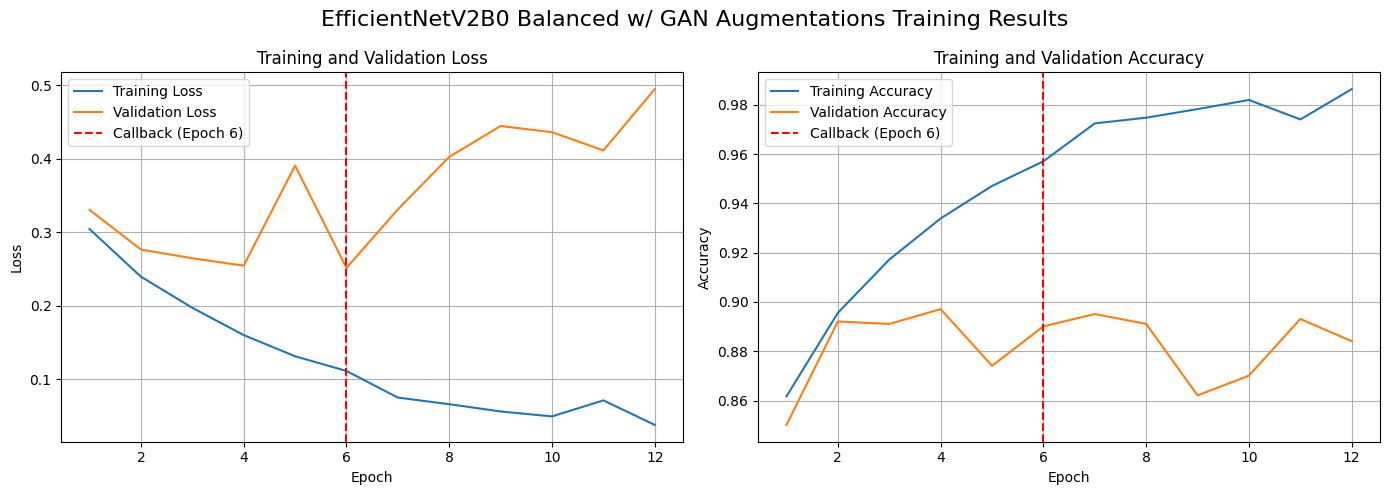

In [5]:
# Defining function for plotting training curves
def plot_training_curves(desc, history_file, callback):
    with open(history_file, "r") as f:
        history = json.load(f) # Loading training history

    # Extracting metrics from history
    epochs = history["epoch"]
    train_loss = history["loss"]
    train_acc = history["accuracy"]
    val_loss = history["val_loss"]
    val_acc = history["val_accuracy"]

    # Plotting training and validation loss curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{desc} Training Results", fontsize=16)
    ax1.plot(epochs, train_loss, label="Training Loss")
    ax1.plot(epochs, val_loss, label="Validation Loss")
    ax1.axvline(x=callback, color='red', linestyle='--', label=f"Callback (Epoch {callback})")
    ax1.set_title(f"Training and Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plotting training and validation accuracy curves
    ax2.plot(epochs, train_acc, label="Training Accuracy")
    ax2.plot(epochs, val_acc, label="Validation Accuracy")
    ax2.axvline(x=callback, color='red', linestyle='--', label=f"Callback (Epoch {callback})")
    ax2.set_title(f"Training and Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

histories = [["training_history_LN_none.json", 5],
             ["training_history_LN_manual.json", 4],
             ["training_history_LN_gs.json", 12],
             ["training_history_LN_gan.json", 5],
             ["training_history_EN_none.json", 3],
             ["training_history_EN_manual.json", 3],
             ["training_history_EN_gs.json", 2],
             ["training_history_EN_gan.json", 6],
             ]

# Calling plotting function
for i in range (0,len(models)):
    plot_training_curves(models[i][1], histories[i][0], histories[i][1])

### Threshold Tuning Capabilities
Outlined in section 3.5.3, results in 4.2.2.

AUC-ROC curves were created using predictions from the validation set to assess threshold tuning options. It was decided that thresholds would be retained at default based off of the strong AUC scores shown.

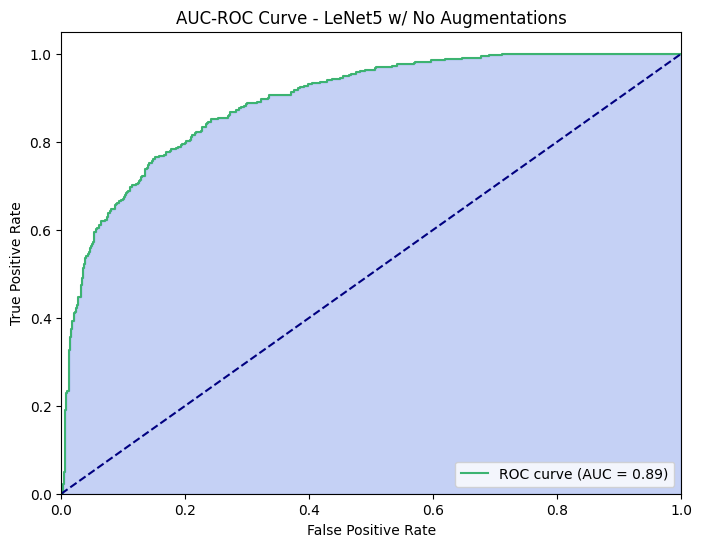

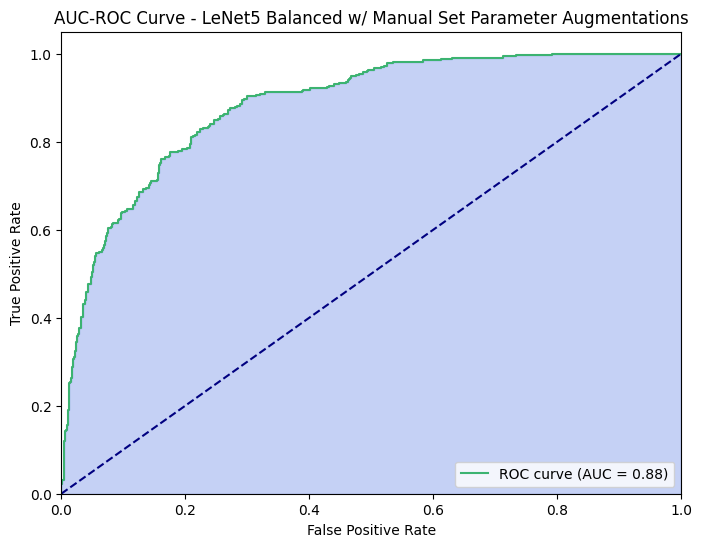

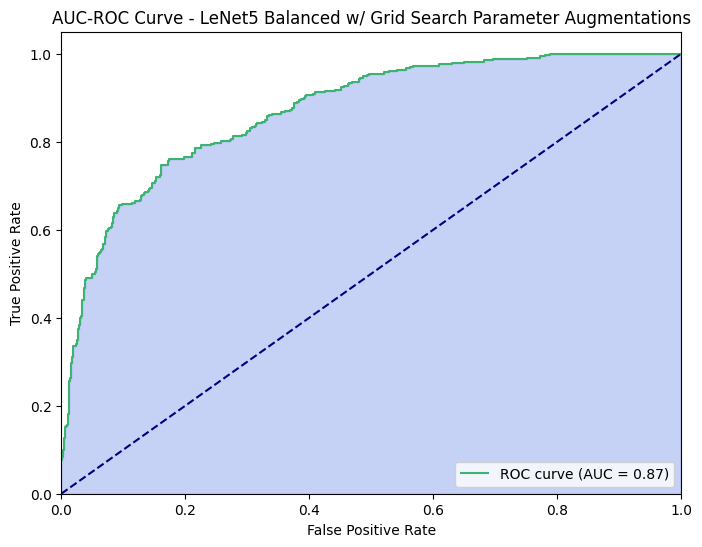

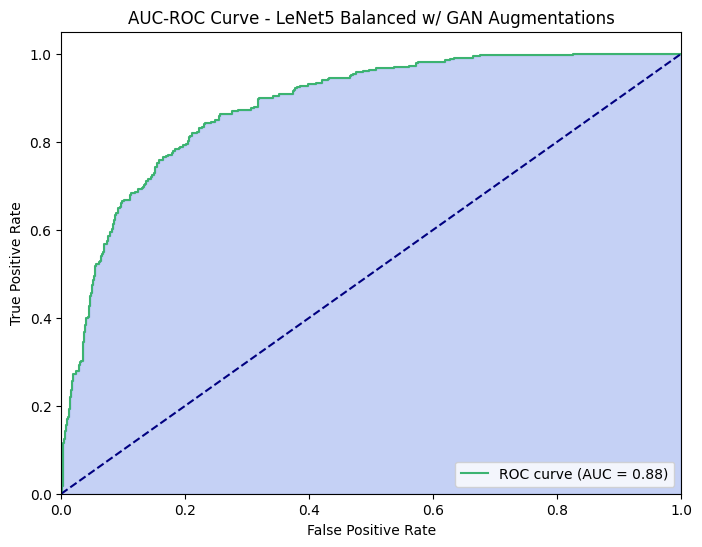

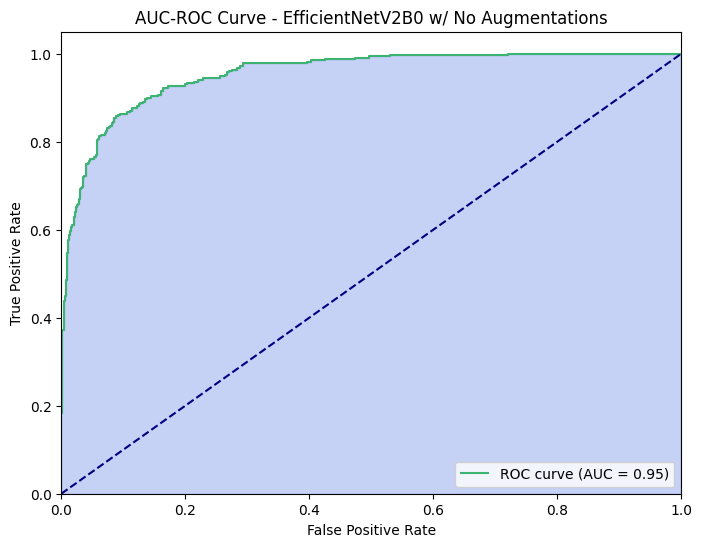

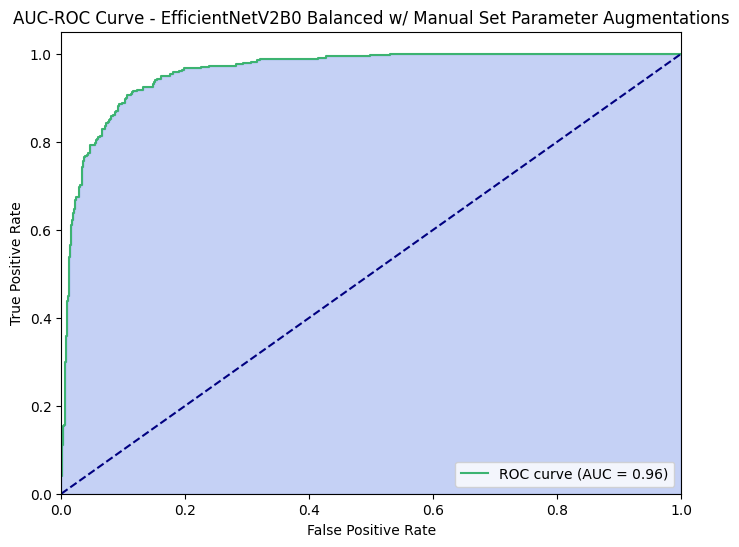

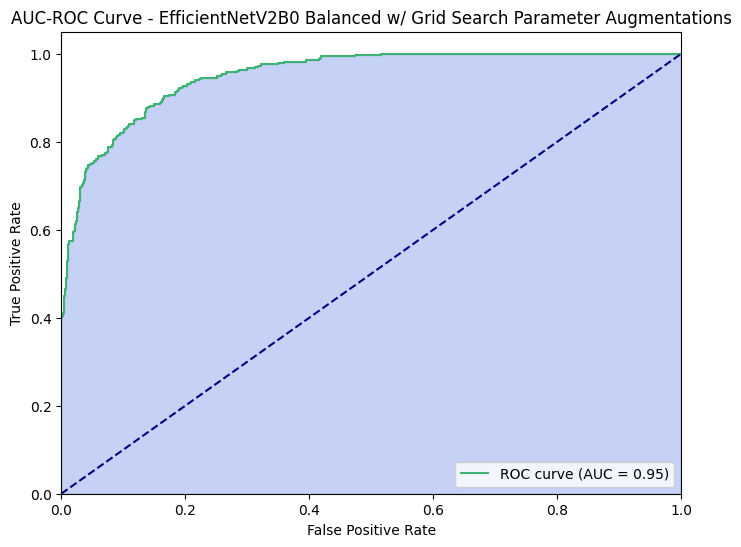

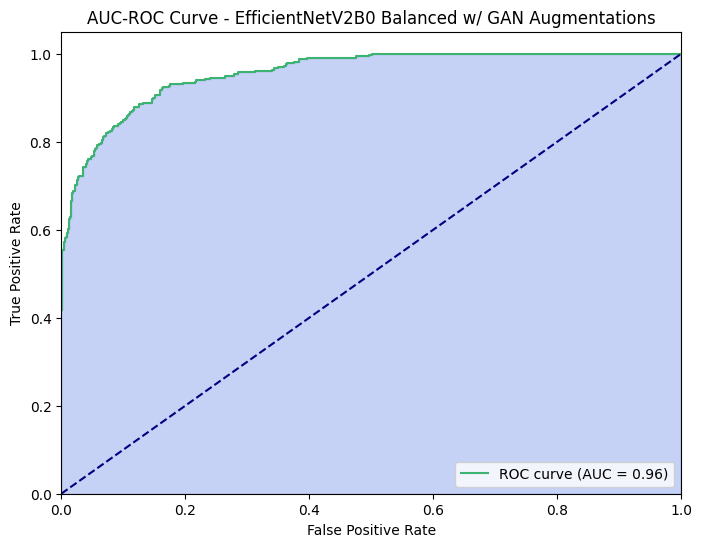

In [6]:
# Defining function to plot AUC-ROC curves
def plot_auc_roc_curve(fpr, tpr, auc_value, desc):
    plt.figure(figsize=(8, 6))
    plt.fill_between(fpr, tpr, color="royalblue", alpha=0.3)
    plt.plot(fpr, tpr, color="mediumseagreen", label=f"ROC curve (AUC = {auc_value:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve - {desc}')
    plt.legend(loc='lower right')
    plt.show()

# Plotting AUC_
for i in range(0, len(models)):
    y_val_pred = models[i][0].predict(x_val, verbose=0)

    # Plotting AUC-ROC curves for comparison
    fpr, tpr, thresholds_val = roc_curve(y_val.argmax(axis=1), y_val_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plot_auc_roc_curve(fpr, tpr, roc_auc, models[i][1])

### Final Evaluation with AUC-ROC Curves and Confusion Matrices
Outlined in section 3.5.4, results in section 4.3.1 - 4.3.3.

Model metrics were evaluated. For visual representations of results, confusion matrices were created, as well as AUC-ROC curves based on the predictions for the unseen test set (after threshold assessment).

Results for LeNet5 w/ No Augmentations with default threshold (0.5):
Accuracy  : 0.8154
Macro F1 Score  : 0.7826
Macro Precision : 0.7982
Macro Recall    : 0.7726



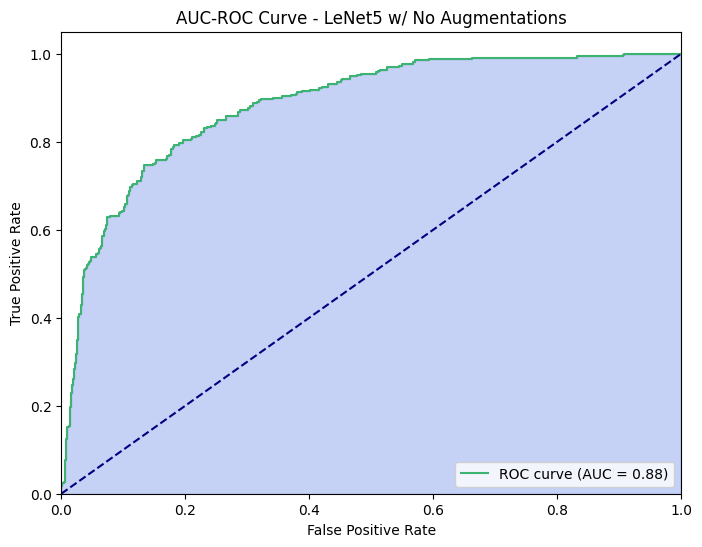

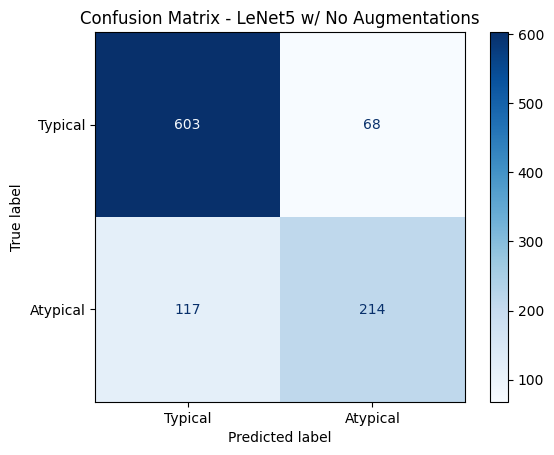

Results for LeNet5 Balanced w/ Manual Set Parameter Augmentations with default threshold (0.5):
Accuracy  : 0.8253
Macro F1 Score  : 0.8054
Macro Precision : 0.8016
Macro Recall    : 0.8099



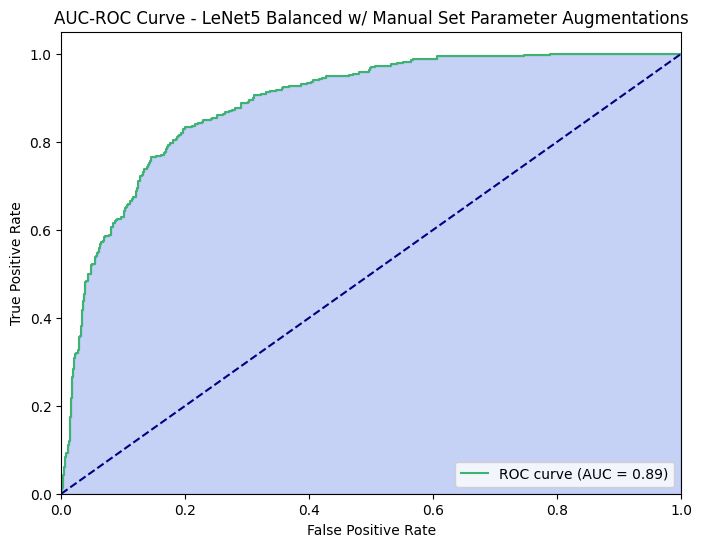

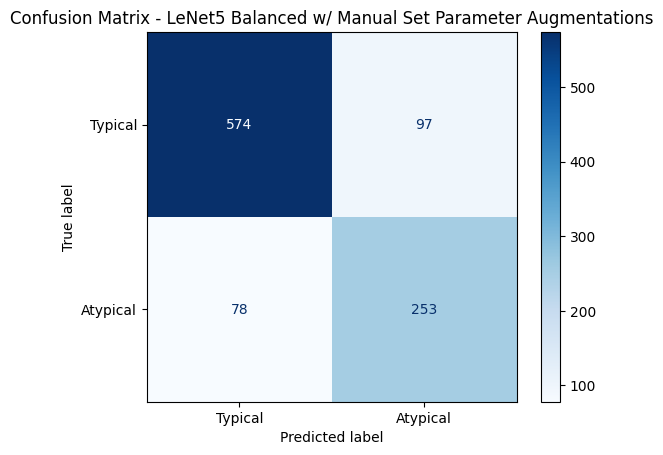

Results for LeNet5 Balanced w/ Grid Search Parameter Augmentations with default threshold (0.5):
Accuracy  : 0.8283
Macro F1 Score  : 0.8002
Macro Precision : 0.8112
Macro Recall    : 0.7922



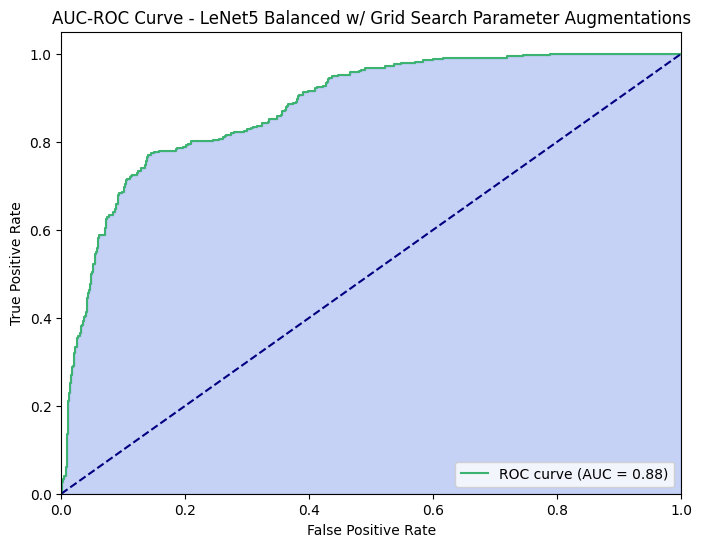

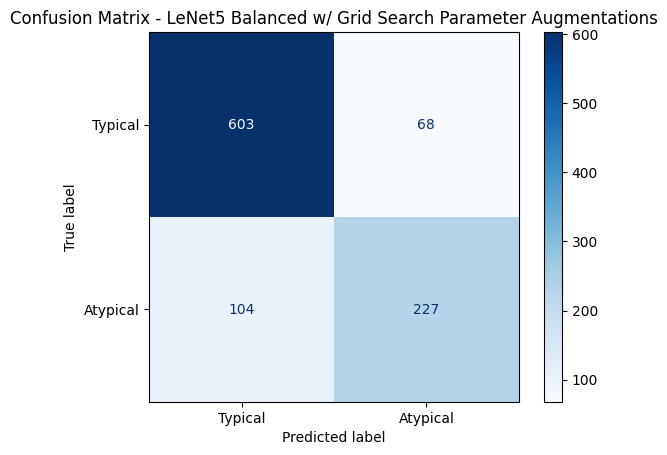

Results for LeNet5 Balanced w/ GAN Augmentations with default threshold (0.5):
Accuracy  : 0.8403
Macro F1 Score  : 0.8175
Macro Precision : 0.8214
Macro Recall    : 0.8142



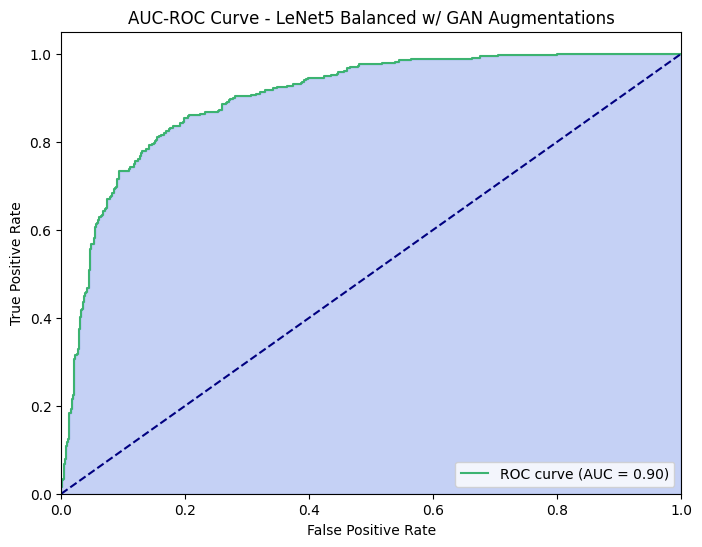

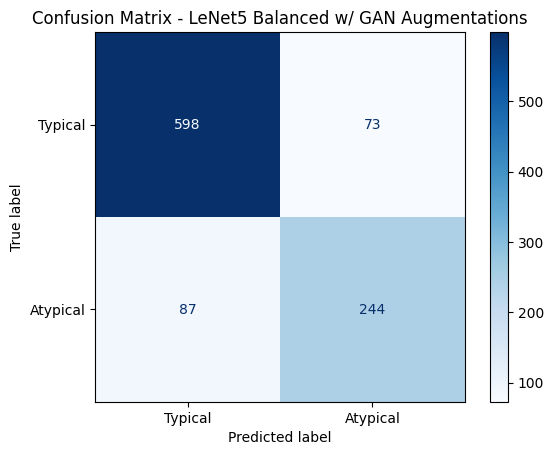

Results for EfficientNetV2B0 w/ No Augmentations with default threshold (0.5):
Accuracy  : 0.8782
Macro F1 Score  : 0.8671
Macro Precision : 0.8582
Macro Recall    : 0.8815



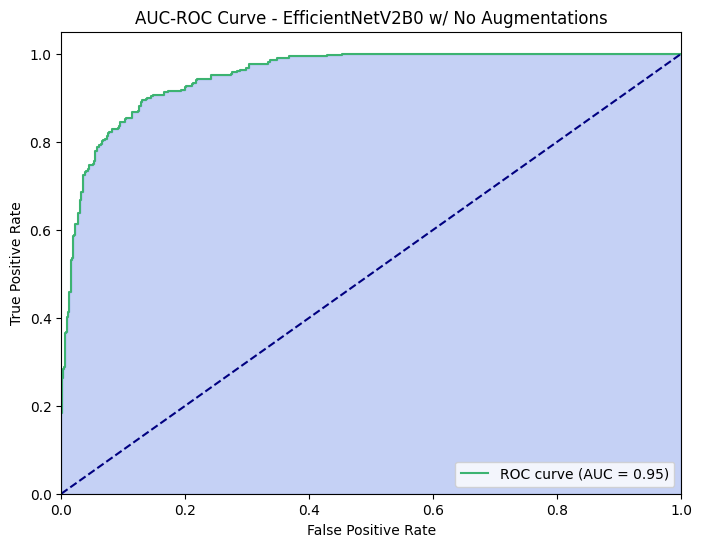

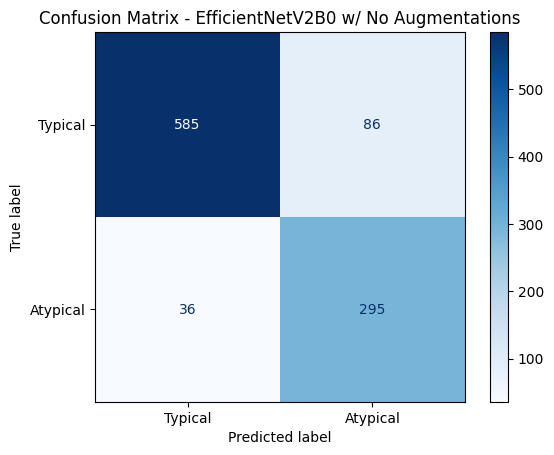

Results for EfficientNetV2B0 Balanced w/ Manual Set Parameter Augmentations with default threshold (0.5):
Accuracy  : 0.9032
Macro F1 Score  : 0.8886
Macro Precision : 0.8967
Macro Recall    : 0.8818



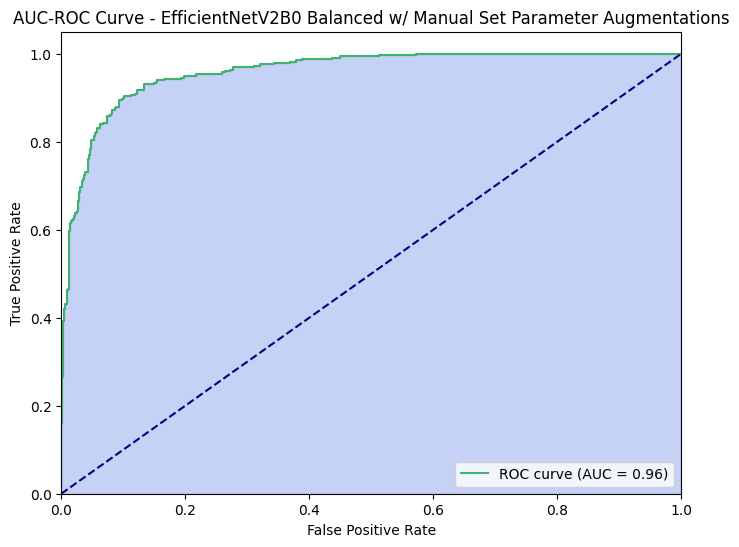

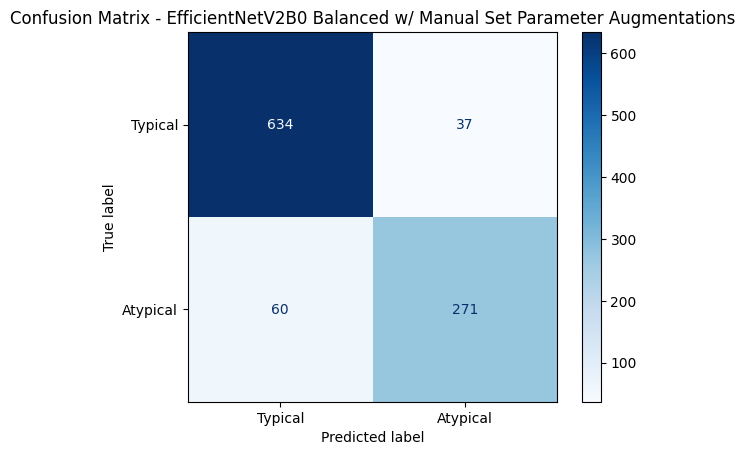

Results for EfficientNetV2B0 Balanced w/ Grid Search Parameter Augmentations with default threshold (0.5):
Accuracy  : 0.8832
Macro F1 Score  : 0.8620
Macro Precision : 0.8837
Macro Recall    : 0.8478



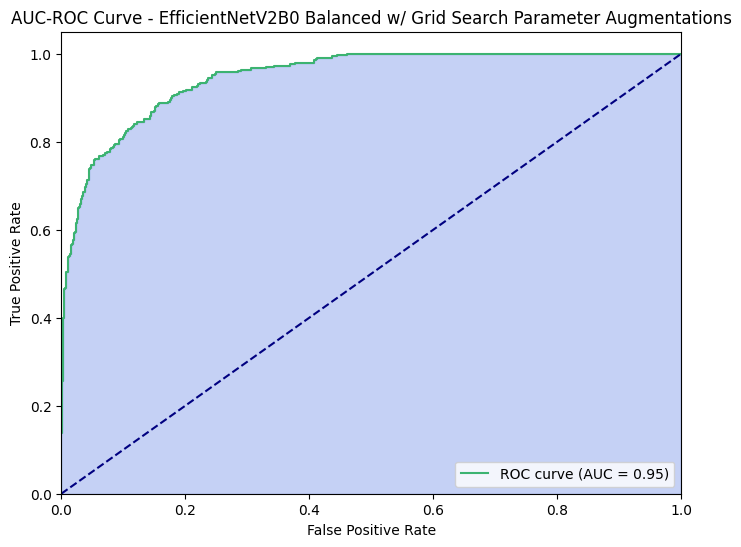

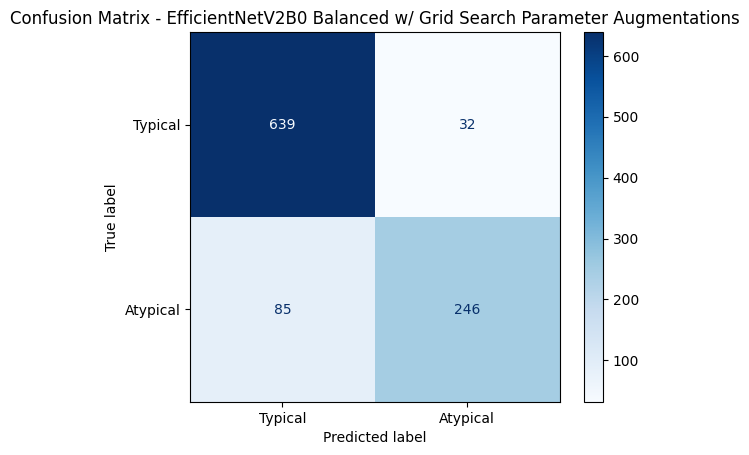

Results for EfficientNetV2B0 Balanced w/ GAN Augmentations with default threshold (0.5):
Accuracy  : 0.8872
Macro F1 Score  : 0.8695
Macro Precision : 0.8797
Macro Recall    : 0.8615



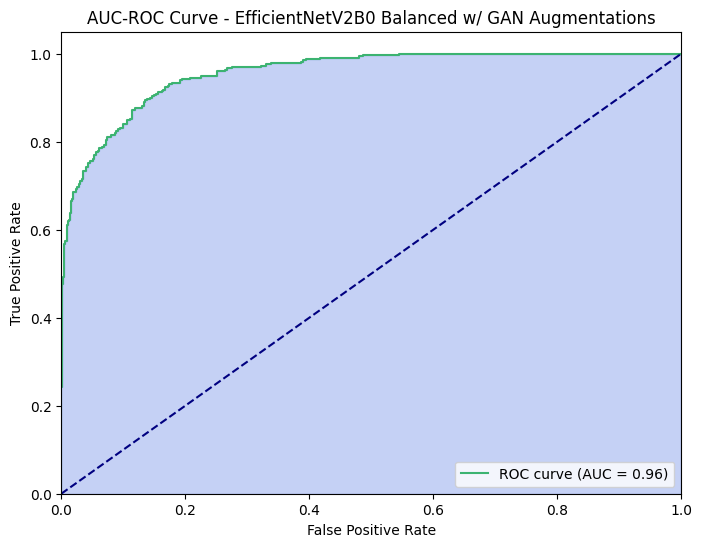

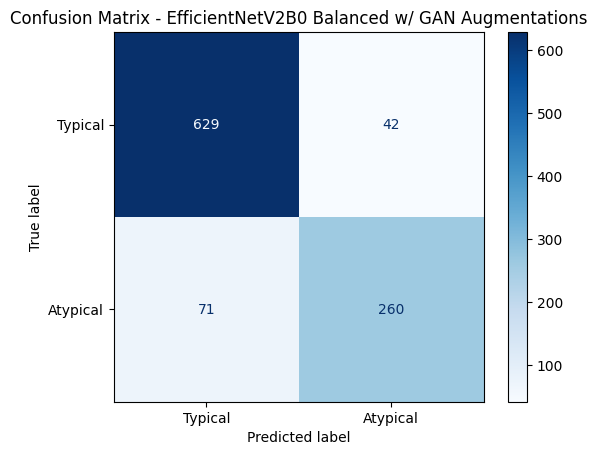

In [7]:
# Defining function to plot confusion matrix
def plot_confusion_matrix(y_true_labels, y_pred_labels, desc):
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Typical", "Atypical"])
    disp.plot(cmap="Blues")
    plt.title(f'Confusion Matrix - {desc}')
    plt.show()

# Defining function for full evaluation using metrics, AUC-ROC curves and confusion matrices
def evaluate(model, desc, x_test, y_test):
    # Obtaining predictions
    y_pred = model.predict(x_test, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Scoring with default threshold
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
    precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro')
    recall_macro = recall_score(y_true_labels, y_pred_labels, average='macro')

    # Displaying results
    print(f"Results for {desc} with default threshold (0.5):")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Macro F1 Score  : {f1_macro:.4f}")
    print(f"Macro Precision : {precision_macro:.4f}")
    print(f"Macro Recall    : {recall_macro:.4f}")
    print("")

    # Plotting AUC-ROC curves for comparison
    fpr, tpr, thresholds_val = roc_curve(y_test.argmax(axis=1), y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plot_auc_roc_curve(fpr, tpr, roc_auc, desc)

    # Plotting confusion matrices for comparison
    plot_confusion_matrix(y_true_labels, y_pred_labels, desc)

    return y_pred_labels, y_true_labels

# Calling function to fully evaluate models
for i in range(0, len(models)):
    y_pred_labels, y_true_labels = evaluate(models[i][0], models[i][1], x_test, y_test)
    models[i].append(y_pred_labels)
    models[i].append(y_true_labels)

### Misclassification Trends
Outlined in section 3.5.4, results in section 4.3.4.

Analysis on where misclassifications stemmed from within the metadata was undertaken, providing insights into the areas where each model struggled with accurately predicting (for medical diagnosis type and localisation of lesion).

In [8]:
# Defining function to check misclassification trends of models
def check_model(test_df, desc, y_pred_labels, y_true_labels, column):
    print(f"Checking mis-classification of {column} for {desc}:")
    df = test_df.copy() # Creating temporary copy of working dataset

    # Adding info to temporary dataset for display
    df["True Label"] = y_true_labels
    df["Predicted Label"] = y_pred_labels
    df["Correct"] = df["True Label"] == df["Predicted Label"]

    # Group by column and calculate misclassification rate
    misclass = df.groupby(column)["Correct"].agg([
        ("Total Samples", "count"),
        ("Correctly Classified", "sum")
    ])
    misclass["Misclassified"] = misclass["Total Samples"] - misclass["Correctly Classified"]
    misclass["Misclassification Rate"] = misclass["Misclassified"] / misclass["Total Samples"]

    # Group by binary class to see distribution within each attribute
    distribution = df.groupby(column)["Detailed Binary Diagnosis"].value_counts().unstack(fill_value=0)
    result = misclass.join(distribution)

    # Sorting result by misclassification rate
    result = result.sort_values("Misclassification Rate", ascending=False)
    display(result)

In [9]:
# Calling function to overview misclassification trends on diagnosis for all models
for i in range(0, len(models)):
    check_model(skin_df_test, models[i][1], models[i][2], models[i][3], "Diagnosis")

Checking mis-classification of Diagnosis for LeNet5 w/ No Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
vasc,12,5,7,0.583333,12,0
mel,108,53,55,0.509259,108,0
df,13,7,6,0.461538,13,0
bkl,110,77,33,0.300000,110,0
akiec,36,29,7,0.194444,36,0
bcc,52,43,9,0.173077,52,0
nv,671,603,68,0.101341,0,671


Checking mis-classification of Diagnosis for LeNet5 Balanced w/ Manual Set Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
vasc,12,5,7,0.583333,12,0
df,13,8,5,0.384615,13,0
mel,108,71,37,0.342593,108,0
bkl,110,87,23,0.209091,110,0
nv,671,574,97,0.144560,0,671
bcc,52,48,4,0.076923,52,0
akiec,36,34,2,0.055556,36,0


Checking mis-classification of Diagnosis for LeNet5 Balanced w/ Grid Search Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
vasc,12,5,7,0.583333,12,0
mel,108,57,51,0.472222,108,0
df,13,9,4,0.307692,13,0
bkl,110,82,28,0.254545,110,0
bcc,52,42,10,0.192308,52,0
akiec,36,32,4,0.111111,36,0
nv,671,603,68,0.101341,0,671


Checking mis-classification of Diagnosis for LeNet5 Balanced w/ GAN Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
vasc,12,5,7,0.583333,12,0
mel,108,65,43,0.398148,108,0
bkl,110,83,27,0.245455,110,0
df,13,10,3,0.230769,13,0
bcc,52,46,6,0.115385,52,0
nv,671,598,73,0.108793,0,671
akiec,36,35,1,0.027778,36,0


Checking mis-classification of Diagnosis for EfficientNetV2B0 w/ No Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
bkl,110,93,17,0.154545,110,0
df,13,11,2,0.153846,13,0
mel,108,92,16,0.148148,108,0
nv,671,585,86,0.128167,0,671
bcc,52,51,1,0.019231,52,0
akiec,36,36,0,0.000000,36,0
vasc,12,12,0,0.000000,12,0


Checking mis-classification of Diagnosis for EfficientNetV2B0 Balanced w/ Manual Set Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
df,13,9,4,0.307692,13,0
mel,108,78,30,0.277778,108,0
vasc,12,10,2,0.166667,12,0
bkl,110,94,16,0.145455,110,0
bcc,52,45,7,0.134615,52,0
nv,671,634,37,0.055142,0,671
akiec,36,35,1,0.027778,36,0


Checking mis-classification of Diagnosis for EfficientNetV2B0 Balanced w/ Grid Search Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
mel,108,57,51,0.472222,108,0
df,13,9,4,0.307692,13,0
bkl,110,87,23,0.209091,110,0
vasc,12,11,1,0.083333,12,0
bcc,52,48,4,0.076923,52,0
akiec,36,34,2,0.055556,36,0
nv,671,639,32,0.047690,0,671


Checking mis-classification of Diagnosis for EfficientNetV2B0 Balanced w/ GAN Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Diagnosis,,,,,,
mel,108,73,35,0.324074,108,0
df,13,9,4,0.307692,13,0
bkl,110,87,23,0.209091,110,0
bcc,52,46,6,0.115385,52,0
akiec,36,33,3,0.083333,36,0
nv,671,629,42,0.062593,0,671
vasc,12,12,0,0.000000,12,0


In [10]:
# Calling function to overview misclassification trends on localisation for all models
for i in range(0, len(models)):
    check_model(skin_df_test, models[i][1], models[i][2], models[i][3], "Localisation")

Checking mis-classification of Localisation for LeNet5 w/ No Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
scalp,9,6,3,0.333333,5,4
foot,26,19,7,0.269231,3,23
chest,39,29,10,0.256410,19,20
genital,4,3,1,0.250000,1,3
face,85,64,21,0.247059,76,9
back,223,170,53,0.237668,74,149
upper extremity,124,98,26,0.209677,51,73
neck,17,14,3,0.176471,8,9
ear,6,5,1,0.166667,2,4


Checking mis-classification of Localisation for LeNet5 Balanced w/ Manual Set Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
ear,6,1,5,0.833333,2,4
genital,4,2,2,0.500000,1,3
scalp,9,5,4,0.444444,5,4
hand,7,4,3,0.428571,1,6
chest,39,29,10,0.256410,19,20
back,223,174,49,0.219731,74,149
upper extremity,124,99,25,0.201613,51,73
neck,17,14,3,0.176471,8,9
foot,26,22,4,0.153846,3,23


Checking mis-classification of Localisation for LeNet5 Balanced w/ Grid Search Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
acral,2,1,1,0.500000,0,2
ear,6,3,3,0.500000,2,4
scalp,9,6,3,0.333333,5,4
chest,39,29,10,0.256410,19,20
genital,4,3,1,0.250000,1,3
unknown,31,24,7,0.225806,8,23
back,223,173,50,0.224215,74,149
upper extremity,124,102,22,0.177419,51,73
face,85,71,14,0.164706,76,9


Checking mis-classification of Localisation for LeNet5 Balanced w/ GAN Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
ear,6,3,3,0.500000,2,4
scalp,9,6,3,0.333333,5,4
chest,39,27,12,0.307692,19,20
hand,7,5,2,0.285714,1,6
genital,4,3,1,0.250000,1,3
neck,17,13,4,0.235294,8,9
foot,26,20,6,0.230769,3,23
back,223,180,43,0.192825,74,149
upper extremity,124,104,20,0.161290,51,73


Checking mis-classification of Localisation for EfficientNetV2B0 w/ No Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
ear,6,3,3,0.500000,2,4
genital,4,3,1,0.250000,1,3
scalp,9,7,2,0.222222,5,4
chest,39,32,7,0.179487,19,20
neck,17,14,3,0.176471,8,9
back,223,189,34,0.152466,74,149
upper extremity,124,108,16,0.129032,51,73
lower extremity,202,178,24,0.118812,57,145
foot,26,23,3,0.115385,3,23


Checking mis-classification of Localisation for EfficientNetV2B0 Balanced w/ Manual Set Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
ear,6,3,3,0.500000,2,4
scalp,9,6,3,0.333333,5,4
genital,4,3,1,0.250000,1,3
back,223,195,28,0.125561,74,149
upper extremity,124,109,15,0.120968,51,73
neck,17,15,2,0.117647,8,9
foot,26,23,3,0.115385,3,23
lower extremity,202,179,23,0.113861,57,145
chest,39,35,4,0.102564,19,20


Checking mis-classification of Localisation for EfficientNetV2B0 Balanced w/ Grid Search Parameter Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
ear,6,4,2,0.333333,2,4
genital,4,3,1,0.250000,1,3
scalp,9,7,2,0.222222,5,4
upper extremity,124,101,23,0.185484,51,73
chest,39,32,7,0.179487,19,20
back,223,188,35,0.156951,74,149
neck,17,15,2,0.117647,8,9
foot,26,23,3,0.115385,3,23
lower extremity,202,179,23,0.113861,57,145


Checking mis-classification of Localisation for EfficientNetV2B0 Balanced w/ GAN Augmentations:


,Total Samples,Correctly Classified,Misclassified,Misclassification Rate,Atypical,Typical
Localisation,,,,,,
ear,6,4,2,0.333333,2,4
genital,4,3,1,0.250000,1,3
chest,39,32,7,0.179487,19,20
back,223,189,34,0.152466,74,149
lower extremity,202,177,25,0.123762,57,145
neck,17,15,2,0.117647,8,9
upper extremity,124,110,14,0.112903,51,73
scalp,9,8,1,0.111111,5,4
face,85,76,9,0.105882,76,9
